In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.13.11



# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Sunday 11/24/19, 11:59PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 3
10 | 15
Total | 55

# Part I - Initial Analysis

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [3]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Sun Nov 17 13:29:52 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Sun Nov 17 13:29:53 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [4]:
labels = original_training_data.columns
nan_values = {}
nan_values_after_change = {}

for label in labels:
    count = sum(pd.isnull(original_training_data[label]))
    nan_values[label] = count

original_training_data.fillna('', inplace=True)

for label in labels:
    count = sum(pd.isnull(original_training_data[label]))
    nan_values_after_change[label] = count

print(nan_values)
print(nan_values_after_change)

{'id': 0, 'subject': 6, 'email': 0, 'spam': 0}
{'id': 0, 'subject': 0, 'email': 0, 'spam': 0}


In [5]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [6]:
first_ham = original_training_data[original_training_data['spam'] == 0].iloc[0, 2]
first_spam = original_training_data[original_training_data['spam'] == 1].iloc[0, 2]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [7]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

The spam email has an HTML text format while the ham email has actual written text.

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [8]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    
    for element in texts:
        indicators = []
        for word in words:
            if word in element:
                indicators.append(1)
            else:
                indicators.append(0)
        indicator_array.append(indicators)
        
    return indicator_array

In [10]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [11]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variables, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variables, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

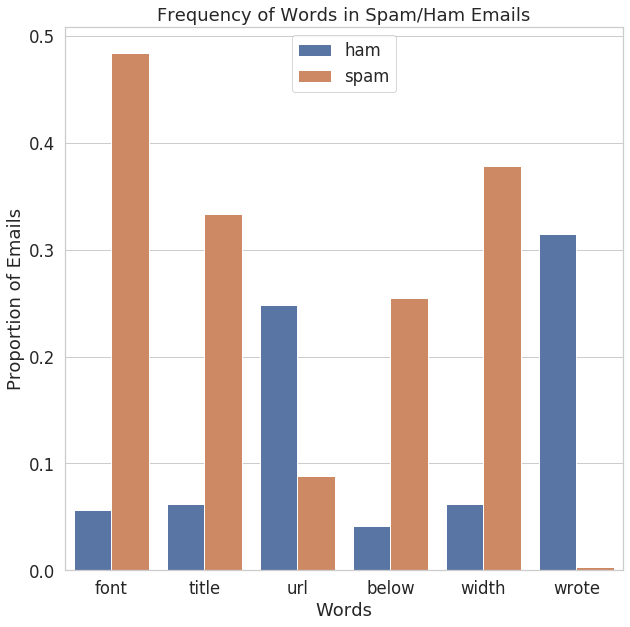

In [12]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
# 'will'
words = ['font', 'title', 'url', 'below', 'width', 'wrote']
series = train['email']
type_label_binary = train['spam']
type_label_nonbinary = ['spam' if item==1 else 'ham' for item in type_label_binary] 

#built counts DataFrame
counts = words_in_texts(words, series)
counts_table = pd.DataFrame(data=counts, columns=words)
counts_table['type'] = type_label_nonbinary

#melted the counts DataFrame, which will unpivot the DataFrame (i.e will turn all columns into rows, except 
#the row identified in the argument of melt - 'type')
melted_counts_table = counts_table.melt('type')

#plotting the requested bar graph
plt.figure(figsize=(10, 10))
sns.barplot(x='variable', y='value', ci=None, hue='type', data=melted_counts_table)
plt.legend(loc='upper center')
plt.xlabel('Words')
plt.ylabel('Proportion of Emails')
plt.title('Frequency of Words in Spam/Ham Emails');

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

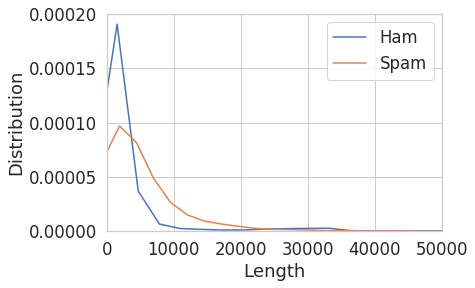

In [13]:
length_of_emails = [len(email) for email in series]

length_and_label_frame = pd.DataFrame(data=length_of_emails, columns=['Length'])
length_and_label_frame['Type'] = type_label_nonbinary

spam_length = length_and_label_frame[length_and_label_frame['Type'] == 'spam']
ham_length = length_and_label_frame[length_and_label_frame['Type'] == 'ham']

sns.distplot(ham_length['Length'], hist=False, label='Ham')
sns.distplot(spam_length['Length'], hist=False, label='Spam')
plt.xlim((0, 50000))
plt.ylabel('Distribution');

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [14]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = pd.DataFrame(data=words_in_texts(some_words, train['email']), columns=some_words)
Y_train = train['spam']

X_train[:5], Y_train[:5]

(   drug  bank  prescription  memo  private
 0     0     0             0     0        0
 1     0     0             0     0        0
 2     0     0             0     0        0
 3     0     0             0     0        0
 4     0     0             0     1        0, 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [15]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)
predictions = model.predict(X_train)

training_accuracy = sum(Y_train == predictions) / len(predictions)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [17]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [18]:
zero_predictor_fp = 0
zero_predictor_fn = sum(Y_train)

In [19]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [20]:
zero_predictor_acc = sum(Y_train == 0) / len(Y_train)
zero_predictor_recall = 0

In [21]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

Since we are classify all emails as ham we will have no positives, so we get a value of 0 for FP, TP, and consequently recall. We get approximately a 75% accuracy for the zero_predictor classifier because there are 3 times as many ham emails as spam, so we have a high number of correctly classified ham emails which increases accuracy. Lastly, FN is equal to the number of spam emails in our dataset, namely 1918, because we have falsely classified them all as ham and because we have correctly classified all ham emails.

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [22]:
tp = sum((Y_train == predictions) & (Y_train == 1))
fp = sum((Y_train != predictions) & (Y_train == 0))
tn = sum((Y_train == predictions) & (Y_train == 0))
fn = sum((Y_train != predictions) & (Y_train == 1))

logistic_predictor_precision = tp / (tp + fp)
logistic_predictor_recall = tp / (tp + fn)
logistic_predictor_far = fp / (fp + tn)

print('False positives: ', fp, 'False negatives: ', fn)

False positives:  122 False negatives:  1699


In [23]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

There are significantly more false negatives than false positives for our trained classifier.

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

1. We got around the same accuracy rate for our zero predictor as our trained classifier (~75%).

2. It's possible the words that were more frequent in spam emails vs ham emails are overall not very prevalent in our dataset. Thus, these features are not good at correctly classifying emails as spam, as evidenced by our number of false negatives.

3. Note that the number of false positives for our trained classifier is 122 emails, while the number of false positives for the zero classifier is 0. A false positive is an email that has been classified as spam when it was actually ham, causing the email to be discarded from my view. This is not good, personally, as many important corespondences could potentially be lost. If I was to use a classifier to sort through my emails, I would pick a classifier that makes sure I get as many ham emails as possible. For this reasoning, I would pick the zero classifier over the trained classifier. 

# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 10).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

# Looking at the relationship between ham/spam emails and their subject lengths. 

Conclusion: Their lengths seem to be distributed about the same so this feature will probably not be useful in distinguishing between the two categories.

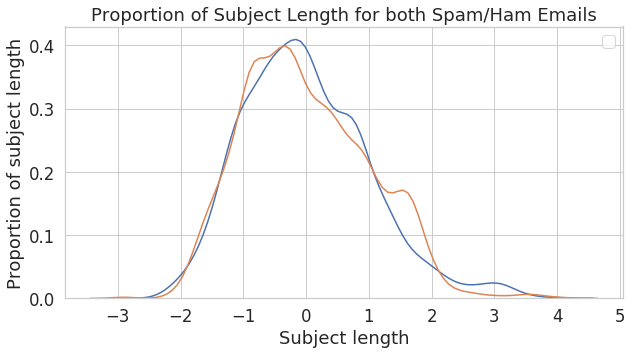

In [24]:
#grab subject headers from train dataset so we can calculate the length of each
subject_lines = train['subject']
subject_length = []

#append length of each subject line into list SUBJECT_LENGTH; if subject line is int, append length = 1 to list
for subject in subject_lines:
    if isinstance(subject, str):
        subject_length.append(len(subject))
    else:
        subject_length.append(1)

#adding subject length to copy of dataFrame TEST
train_with_sbjlength = train.copy()
train_with_sbjlength['Subject length'] = subject_length

#plotting distribution of length for both spam and ham emails (length data is normalized)
spam_length_frame = train_with_sbjlength[train_with_sbjlength['spam'] == 1]
ham_length_frame = train_with_sbjlength[train_with_sbjlength['spam'] == 0]

plt.figure(figsize=(10, 5))
sns.distplot((spam_length_frame['Subject length'] - np.mean(spam_length_frame['Subject length']))/ np.std(spam_length_frame['Subject length']), hist=False)
sns.distplot((ham_length_frame['Subject length'] - np.mean(ham_length_frame['Subject length']))/ np.std(ham_length_frame['Subject length']), hist=False)
plt.ylabel('Proportion of subject length')
plt.title('Proportion of Subject Length for both Spam/Ham Emails')
plt.legend(['Spam', 'Ham']);

# We now explore the relationship between punctuation and spam/ham emails.

Conclusion: Although the distributions have different medians, I think the distributions of punctuation for spam and ham emails are too close to be a good factor in distringuising between the categories.

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


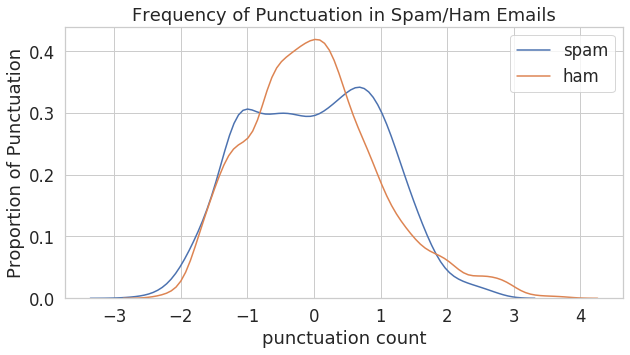

In [25]:
#need list of punctuation for the purpose of this investigation
import string

#grab each category separately from the dataframe
spam_only = train[train['spam'] == 1]
ham_only = train[train['spam'] == 0]

punctuation_nonlist = string.punctuation
punctuation_list = []

#build a list of punctuation so we can use it in our words_in_texts function
for i in np.arange(len(punctuation_nonlist)):
    punctuation_list.append(punctuation_nonlist[i])


#find the amount of punctuation in spam/ham emails
punctuation_counts_spam = words_in_texts(punctuation_list, spam_only['email'])
punctuation_counts_ham = words_in_texts(punctuation_list, ham_only['email'])

#sum the number of punctuation characters in each email so we can plot the distribution
count_per_email_spam = [sum(count) for count in punctuation_counts_spam]
count_per_email_ham = [sum(count) for count in punctuation_counts_ham]

#we now append these counts to the spam only and ham only dataframe above
spam_only['punctuation count'] = count_per_email_spam
ham_only['punctuation count'] = count_per_email_ham

#we not plot the distribution of punctuation in both spam and ham emails; data has been normalized
plt.figure(figsize=(10, 5))
sns.distplot((spam_only['punctuation count'] - np.mean(spam_only['punctuation count'])) / np.std(spam_only['punctuation count']), hist=False, label='spam')
sns.distplot((ham_only['punctuation count'] - np.mean(ham_only['punctuation count']))/ np.std(ham_only['punctuation count']), hist=False, label='ham');
plt.ylabel('Proportion of Punctuation')
plt.title('Frequency of Punctuation in Spam/Ham Emails');

# We now look to see whether a reply-to or forwarded email can distinguish between the spam, ham categories

Conclusion: We see that the keyword 'Re' in the subject line is a clear indicator of whether the email is ham or spam. We will use this as a feature in our training set

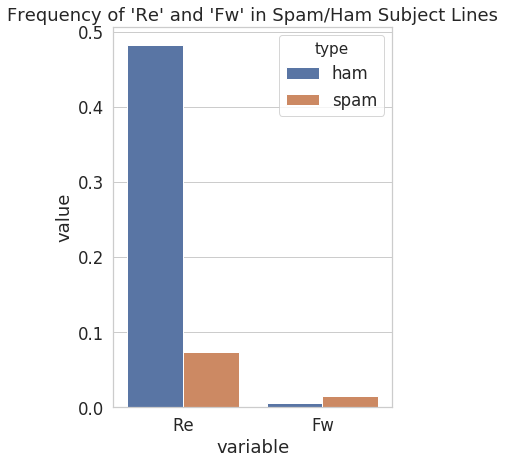

In [26]:
#initialize a list with the words that distinguish an email as a reply or a forward
reply_or_forward = ['Re', 'Fw']

#we gather the counts of the words in each email in the training dataset
counts_of_re_fw = words_in_texts(reply_or_forward, train['subject'])

#we create a dataframe with these counts so that we can melt it for plotting convenience
counts_table_re_fw = pd.DataFrame(data=counts_of_re_fw, columns=reply_or_forward)
counts_table_re_fw['type'] = type_label_nonbinary
counts_table_re_fw

#melted the counts of re/fw DataFrame, which will unpivot the DataFrame (i.e will turn all columns into rows, except 
#the row identified in the argument of melt - 'type')
melted_counts_refw_table = counts_table_re_fw.melt('type')
melted_counts_refw_table

#we now look at the distribution of spam, ham emails with re or fw in the subject line
plt.figure(figsize=(5, 7))
sns.barplot(x='variable', y='value', ci=False, hue='type', data=melted_counts_refw_table)
plt.title("Frequency of 'Re' and 'Fw' in Spam/Ham Subject Lines");

In the cell below we create a copy of the train table and add the binary feature of whether the subject line contains the word 'Re'.

In [27]:
#make a copy of the original train data and add the new binary feature
train_with_re_count = train.copy()
has_re = [1 if counts_of_re_fw[i][0] == 1 else 0 for i in np.arange(len(counts_of_re_fw))]

train_with_re_count["Contains 'Re'"] = has_re

We not do the same for our validation and test set so that all features are present for each set.

In [28]:
#make a copy of the test and validation sets and add the new feature
test_with_re_count = test.copy()
val_with_re_count = val.copy()

#we found that one subject title in the test set was a null value so we change it to the string 'None'
types = [type(subject) for subject in test['subject']]
index_of_float = types.index(float)
subjects = test_with_re_count['subject']
subjects[index_of_float] = 'None'

#we now update the copy our test dataset to conatin this change for the subject line
test_with_re_count['subject'] = subjects

#we now find the counts in each set of 'Re', 'Fw'
counts_of_re_fw_test = words_in_texts(reply_or_forward, test_with_re_count['subject'])
counts_of_re_fw_val = words_in_texts(reply_or_forward, val_with_re_count['subject'])

#we narrow down lists above to the 'Re' count only
has_re_test = [1 if counts_of_re_fw_test[i][0] == 1 else 0 for i in np.arange(len(counts_of_re_fw_test))]
has_re_val = [1 if counts_of_re_fw_val[i][0] == 1 else 0 for i in np.arange(len(counts_of_re_fw_val))]

#update our test, val dataFrames
test_with_re_count["Contains 'Re'"] = has_re_test
val_with_re_count["Contains 'Re'"] = has_re_val

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# We now investigate whether a model trained to look for certain words will be useful in distinguishing between categories

Conclusion: The chosen words, including whether 'Re' is present in the subject line, are decent features to help with categorizing between spam and ham. We reached a training accuracy of about 87.12% but note this is not enough to reach the 88% threshold. We also did terribly on the validation set, so we choose a new set of features.

In [29]:
#a list of words and characters that appear frequently in our training dataset and that could potential help with classification
chosen_words = ['font', 'title', 'url', 'below', 'width', 'wrote', '!', 'html', 'please', '=', 'your', 'as']

#we grab the counts of each word in CHOSEN_WORDS so that we may add this to our training dataset
counts_of_chosen_words = words_in_texts(chosen_words, train['email'])

#creating a dataFrame with the word counts
key_id = train_with_re_count.id #will help with merging
training_set_copy = train_with_re_count.copy()
word_count_df = pd.DataFrame(data=counts_of_chosen_words, columns=chosen_words)
word_count_df['id'] = key_id

#merging word counts table with training table
train_words_merged = train_with_re_count.merge(word_count_df)

#we not train a logistic regression model with this observation matrix
Y_train = train_words_merged['spam']
X_train = train_words_merged.iloc[:, 4:]

words_model_improved = LogisticRegression()
words_model_improved.fit(X_train, Y_train)
training_predictions = words_model_improved.predict(X_train)

#we now measure the training accuracy of this model
training_accuracy = sum(training_predictions == Y_train) / len(training_predictions)
print('Training accuracy of words and re model: ', training_accuracy, '%')

Training accuracy of words and re model:  0.8691601224544123 %


In [30]:
#we now use our validation set to test accuracy
counts_of_chosen_words_val = words_in_texts(chosen_words, val['email'])

#creating a dataFrame with the word counts
key_id_val = val_with_re_count.id #will help with merging
word_count_val_df = pd.DataFrame(data=counts_of_chosen_words_val, columns=chosen_words)
word_count_val_df['id'] = key_id_val

#merging word counts table with training table
val_words_merged = val_with_re_count.merge(word_count_val_df)

#we not train a logistic regression model with this observation matrix
Y_test_val = val_words_merged['spam']
X_test_val = val_words_merged.iloc[:, 4:]

val_predictions = words_model_improved.predict(X_test_val)

validation_accuracy = sum(val_predictions == Y_test_val) / len(val_predictions)
print('Validation accuracy of words and re model: ', validation_accuracy, '%')

Validation accuracy of words and re model:  0.6363636363636364 %


# Using Collections class' counter method to find distinct features to increase validation accuracy

Conclusion: Success!! This class helped us identify some distinct features to use to train our model - we reached a training accuracy of 93% and a validation accuracy of 94%.

In [31]:
import collections

#grabbing all the words in ham emails and finding the 100 most common
ham_emails = train[train['spam'] == 0].email
ham_words = []
for email in ham_emails:
    ham_words.append(email.split())

flattened_words_ham = [item for sublist in ham_words for item in sublist]

counted_ham = collections.Counter(flattened_words_ham).most_common(100)

#grabbing all the words in spam emails and finding the 100 most common
spam_emails = train[train['spam'] == 1].email
spam_words = []
for email in spam_emails:
    spam_words.append(email.split())

flattened_words_spam = [item for sublist in spam_words for item in sublist]

counted_spam = collections.Counter(flattened_words_spam).most_common(100)

#grabbing just the words and not the count of each word
common_spam = [x for (x,y) in counted_spam]
common_ham = [x for (x,y) in counted_ham]

#building a list of distinct features to help with training a model
distinct_features = []
for word in common_spam:
    if word not in common_ham:
        distinct_features.append(word)

for word in common_ham:
    if (word not in distinct_features) & (word not in common_spam):
        distinct_features.append(word)

#building a matrix with counts of 76 words in DISTINCT_FEATURES and training our model with these features
counts = words_in_texts(distinct_features, train['email'])
X_train_distinct = pd.DataFrame(data=counts, columns=distinct_features)
Y_train_distinct = train['spam']

improved_model = LogisticRegression()
improved_model.fit(X_train_distinct, Y_train_distinct)
predictions_improved = improved_model.predict(X_train_distinct)

#determinig the accurac of this model
accuracy_improved = sum(Y_train_distinct == predictions_improved) / len(predictions_improved)

#testing on validation set
val_counts = words_in_texts(distinct_features, val['email'])
val_matrix = pd.DataFrame(data=val_counts, columns=distinct_features)
Y_val = val['spam']
val_predictions = improved_model.predict(val_matrix)

#determinig the accuracy of our model
val_accuracy = sum(Y_val == val_predictions) / len(val_predictions)
print('Training accuracy: ', accuracy_improved, ' Validation accuracy: ', val_accuracy)

Training accuracy:  0.926926660455211  Validation accuracy:  0.9365269461077844


### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

I investigated a couple suggestions on how to find better features such as length of subject line, amount of punctuation in the email, and whether an email was a reply-to or a forward. The first two features ended up showing the same distribution for ham and spam emails so I concluded that they would not be useful in distinguishing between email type. I did find that the feature of having 'Re' in the subject linee (reply-to email) would be useful in detecting ham emails as it was much more prevlalent. I also skimmed a bunch of spam and ham emails to pick about 10 words that were seen more frequently in either ham or spam. I used these words, along with the 'Re' feature, to train my first model but it did not generalize well (training accuracy 87% while validation accuracy 65%). I eventually found the Collections class' counter method which enabled me to find 76 distinct words found in ham/spam emails. With these features I was able to reach a training accuracy of 93% and a validation accuracy of 94%. I found it interesting that out of 100 common features in both spam and ham emails only about 76 of them (out of 200 total) were distinct in both sets. I can see why it was a challenge to find distinct words by inspection - thank god for technology!

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

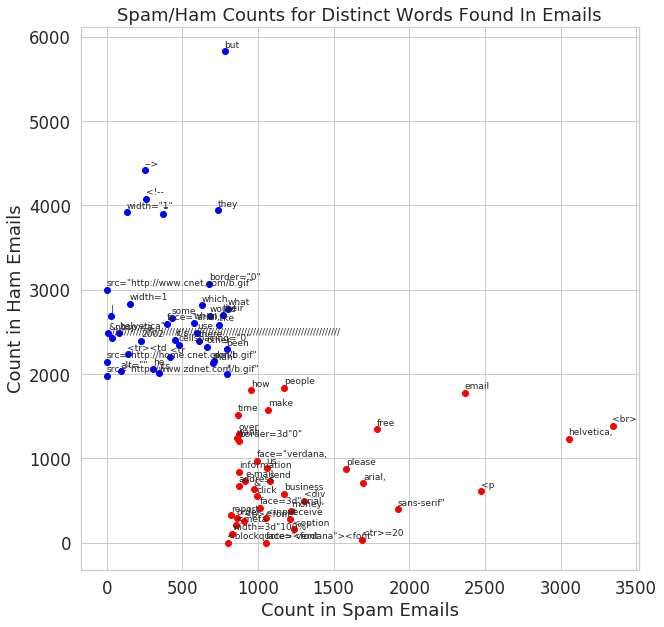

In [32]:
# Write your description (2-3 sentences) as a comment here:
# 
# I had a hard time finding features that were distinct in both spam, ham emails. I created a scatter plot below of the
# count of words that I collected from both types of emails using the counter method from the Collections class and picked 
# the ones that had a high count for one category and a low count for the other. Meaning, I picked words that were found 
# in the top left corner of the plot and the bottom right corner of the plot. Note: the difference of color is whether
# the word was distinct among spam or ham emails - red is for spam and blue is for ham.
#

# Write the code to generate your visualization here:


def find_distinct(pair_list):
    """Takes in a list of (x,y) pairs, where x is a word and y is the count of the word in an email category,
    and returns a list of (x,y) pairs for words that are found in the distinct_features list"""
    distinct_pairs = []
    for pair in pair_list:
        if pair[0] in distinct_features:
            distinct_pairs.append(pair)
    return distinct_pairs

#compile list of words and their respective counts that are distinct in both categories
ham_distinct_pairs = find_distinct(counted_ham)
spam_distinct_pairs = find_distinct(counted_spam)

#compile list of words found in distinct pairs above so we may plot the word on the scatter plot
distinct_for_ham = [x for (x,y) in ham_distinct_pairs]
distinct_for_spam = [x for (x,y) in spam_distinct_pairs]
        

def corresponding_coordinate(distinct_pairs, flattened_list):
    """"Takes in a list of distinct pairs of one email category and a list of words from the 
    opposite category and returns a list of the counts of each word from the opposite cateogry"""
    corresponding_coordinates = []
    for pair in distinct_pairs:
        word_of_interest = pair[0]
        count = 0
        for word in flattened_list:
            if word == word_of_interest:
                count += 1
        corresponding_coordinates.append(count)
    return corresponding_coordinates

#(x,y) coordinates for distinct ham words
x_1 = corresponding_coordinate(ham_distinct_pairs, flattened_words_spam)
y_1 = [y for (x,y) in ham_distinct_pairs]

#(x,y) coordinates for distinct spam words
y_2 = corresponding_coordinate(spam_distinct_pairs, flattened_words_ham)
x_2 = [y for (x,y) in spam_distinct_pairs]

#plotting both sets of distinct words
plt.figure(figsize=(10, 10))
for i,type in enumerate(distinct_for_ham):
    x_coord = x_1[i]
    y_coord = y_1[i]
    plt.scatter(x_coord, y_coord, marker='o', color='blue')
    plt.text(x_coord-1, y_coord+50, type, fontsize=9)

for i,type in enumerate(distinct_for_spam):
    x_coord = x_2[i]
    y_coord = y_2[i]
    plt.scatter(x_coord, y_coord, marker='o', color='red')
    plt.text(x_coord-1, y_coord+50, type, fontsize=9)

#plt.legend(['Distinct Ham Words', 'Distinct Spam Words'])
plt.ylabel('Count in Ham Emails')
plt.xlabel('Count in Spam Emails')
plt.title('Spam/Ham Counts for Distinct Words Found In Emails');

### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle). Refer to the Lecture 22 notebook or Section 17.7 of the course text to see how to plot an ROC curve.



<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

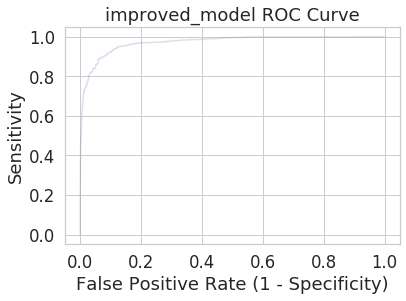

In [33]:
from sklearn.metrics import roc_curve

# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

improved_model_probabilities = improved_model.predict_proba(X_train_distinct)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(Y_train_distinct, improved_model_probabilities, pos_label=1)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('improved_model ROC Curve');

# Gathering relevent features from test set so that I can finally measure the performance of my model to submit to Kaggle

In [34]:
#we collect counts of chosen words in test set emails
counts_of_distinct_features_test = words_in_texts(distinct_features, test['email'])

#creating a dataFrame with the word counts
key_id_test = test.id #will help with merging
word_count_test_df = pd.DataFrame(data=counts_of_distinct_features_test, columns=distinct_features)
word_count_test_df['id'] = key_id_test

#merging word counts table with test table
copy_of_test = test.copy()
test_words_merged = copy_of_test.merge(word_count_test_df, left_on='id', right_on='id')

#create observation matrix of chosen words only
X_test = test_words_merged.iloc[:, 3:]

# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/ds100fa19

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [35]:
test_predictions = improved_model.predict(X_test)

In [36]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [37]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-11-24T15:55:23.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [38]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
This cell has a lot of content! Perhaps try to shorten your response. 



 # Write your description (2-3 sentences) as a comment here:
# 
# I had a hard time finding features that were distinct in both spam, ham emails. I created a scatter plot below of the
# count of words 
Saved proj2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2.ipynb'.
Submit... 100% complete
Submission successful for user: jlgrant@berkeley.edu
URL: https://okpy.org/cal/data100/fa19/proj2/submissions/LZz7Ow

